In [1]:
import tensorflow as tf
print('TensorFlow Version: {}'.format(tf.__version__))
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [3]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    rewards = tf.placeholder(tf.float32, [None], name='rewards')
    dones = tf.placeholder(tf.float32, [None], name='dones')
    rates = tf.placeholder(tf.float32, [None], name='rates') # success rate
    return states, actions, next_states, rewards, dones, rates

In [4]:
def actor(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('actor', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        return logits

In [5]:
def generator(actions, state_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=actions, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=state_size)        
        return logits

In [6]:
def discriminator(states, actions, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        return logits

In [7]:
def model_loss(state_size, action_size, hidden_size, gamma,
               states, actions, next_states, rewards, dones, rates):
    actions_logits = actor(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    aloss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels))
    ###############################################
    next_states_logits = generator(actions=actions_logits, hidden_size=hidden_size, state_size=state_size)
    next_states_labels = tf.nn.sigmoid(next_states)
    aloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=next_states_logits, 
                                                                    labels=next_states_labels))
    ####################################################
    dQs = discriminator(actions=actions_labels, hidden_size=hidden_size, states=states, action_size=action_size)
    rates = tf.reshape(rates, shape=[-1, 1])
    dloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
                                                                   labels=rates)) # 0-1
    ####################################################
    gQs = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states, action_size=action_size, 
                        reuse=True)
    dloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
                                                                    labels=tf.zeros_like(gQs))) # 0-1
    aloss2 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
                                                                    labels=tf.ones_like(gQs))) # 0-1
    #####################################################
    next_actions_logits = actor(states=next_states, hidden_size=hidden_size, action_size=action_size, reuse=True)
    gQs2 = discriminator(actions=next_actions_logits, hidden_size=hidden_size, states=next_states, 
                         action_size=action_size, reuse=True)
    gQs2 = tf.reshape(gQs2, shape=[-1]) * (1-dones)
    aloss2 += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs2, # GAN
                                                                     labels=tf.ones_like(gQs2))) # 0-1
    return actions_logits, aloss, dloss, aloss2, (1-dones)

In [8]:
def model_opt(a_loss, a_loss2, d_loss, a_learning_rate, d_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    a_vars = [var for var in t_vars if var.name.startswith('actor')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        a_opt = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss, var_list=a_vars)
        d_opt = tf.train.AdamOptimizer(d_learning_rate).minimize(d_loss, var_list=d_vars)
        a_opt2 = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss2, var_list=a_vars)
    return a_opt, d_opt, a_opt2

In [9]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, a_learning_rate, d_learning_rate, gamma):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.next_states, self.rewards, self.dones, self.rates = model_input(
            state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.a_loss, self.d_loss, self.a_loss2, self.dones__ = model_loss(
            state_size=state_size, action_size=action_size, hidden_size=hidden_size, gamma=gamma, # model init
            states=self.states, actions=self.actions, next_states=self.next_states, #model input 
            rewards=self.rewards, dones=self.dones, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.a_opt, self.d_opt, self.a_opt2 = model_opt(a_loss=self.a_loss, 
                                                        a_loss2=self.a_loss2, 
                                                        d_loss=self.d_loss,
                                                        a_learning_rate=a_learning_rate,
                                                        d_learning_rate=d_learning_rate)

In [10]:
# def sample(buffer, batch_size):
#     idx = np.random.choice(np.arange(len(buffer)), size=batch_size, replace=False)
#     return [buffer[ii] for ii in idx]

In [11]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [12]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [13]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
a_learning_rate = 1e-4         # Q-network learning rate
d_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size: 200/500 a successfull episode size
gamma = 0.99                   # future reward discount

In [14]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size,
              a_learning_rate=a_learning_rate, d_learning_rate=d_learning_rate, gamma=gamma)

# Init the memory
memory = Memory(max_size=memory_size)

In [15]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    rate = -1
    memory.buffer.append([state, action, next_state, reward, float(done), rate])
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        state = env.reset()
        rate = total_reward/500
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1:
                memory.buffer[-1-idx][-1] = rate
        total_reward = 0 # reset
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [ ]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list = [], []
# aloss_list, dloss_list, aloss2_list = [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window

    # Training episodes/epochs
    for ep in range(11111):
        total_reward = 0 # each episode
        aloss_batch, dloss_batch, aloss2_batch = [], [], []
        state = env.reset() # each episode
        num_step = 0 # each episode

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            rate = -1
            memory.buffer.append([state, action, next_state, reward, float(done), rate])
            num_step += 1 # momory added
            total_reward += reward
            state = next_state
            
            # Rating the memory
            if done is True:
                rate = total_reward/500 # update rate at the end/ when episode is done
                for idx in range(num_step): # episode length
                    if memory.buffer[-1-idx][-1] == -1: # double-check the landmark/marked indexes
                        memory.buffer[-1-idx][-1] = rate # rate the trajectory/data
                        
            # Training with the maxrated minibatch
            batch = memory.buffer
            #for idx in range(memory_size// batch_size):
            idx = np.random.choice(np.arange(memory_size// batch_size))
            states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rates = np.array([each[5] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            states = states[rates == np.max(rates)]
            actions = actions[rates == np.max(rates)]
            next_states = next_states[rates == np.max(rates)]
            rewards = rewards[rates == np.max(rates)]
            dones = dones[rates == np.max(rates)]
            rates = rates[rates == np.max(rates)]
            aloss, dloss, _, _ = sess.run([model.a_loss, model.d_loss, model.a_opt, model.d_opt],
                                          feed_dict = {model.states: states, 
                                                       model.actions: actions,
                                                       model.next_states: next_states,
                                                       model.rewards: rewards,
                                                       model.dones: dones,
                                                       model.rates: rates})
            aloss2, _, dones__ = sess.run([model.a_loss2, model.a_opt2, model.dones__], 
                                 feed_dict = {model.states: states, 
                                              model.actions: actions,
                                              model.next_states: next_states,
                                              model.rewards: rewards,
                                              model.dones: dones,
                                              model.rates: rates})
            #print(dones__, np.max(rates), rates.shape, dones)
            aloss_batch.append(aloss)
            dloss_batch.append(dloss)
            aloss2_batch.append(aloss2)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'aloss:{:.4f}'.format(np.mean(aloss_batch)),
              'dloss:{:.4f}'.format(np.mean(dloss_batch)),
              'aloss2:{:.4f}'.format(np.mean(aloss2_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        # gloss_list.append([ep, np.mean(gloss_batch)])
        # dloss_list.append([ep, np.mean(dloss_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:22.0000 R:22.0000 rate:0.0440 aloss:1.4010 dloss:1.4059 aloss2:1.4632 exploreP:0.9978
Episode:1 meanR:21.5000 R:21.0000 rate:0.0420 aloss:1.3988 dloss:1.3615 aloss2:1.5159 exploreP:0.9958
Episode:2 meanR:23.3333 R:27.0000 rate:0.0540 aloss:1.3952 dloss:1.3713 aloss2:1.4947 exploreP:0.9931
Episode:3 meanR:20.5000 R:12.0000 rate:0.0240 aloss:1.3944 dloss:1.3528 aloss2:1.5203 exploreP:0.9919
Episode:4 meanR:19.8000 R:17.0000 rate:0.0340 aloss:1.3989 dloss:1.3205 aloss2:1.5482 exploreP:0.9902
Episode:5 meanR:21.5000 R:30.0000 rate:0.0600 aloss:1.3973 dloss:1.3528 aloss2:1.5023 exploreP:0.9873
Episode:6 meanR:20.4286 R:14.0000 rate:0.0280 aloss:1.4047 dloss:1.3079 aloss2:1.5479 exploreP:0.9859
Episode:7 meanR:19.8750 R:16.0000 rate:0.0320 aloss:1.4019 dloss:1.3113 aloss2:1.5305 exploreP:0.9844
Episode:8 meanR:19.6667 R:18.0000 rate:0.0360 aloss:1.3994 dloss:1.2883 aloss2:1.5675 exploreP:0.9826
Episode:9 meanR:20.0000 R:23.0000 rate:0.0460 aloss:1.3992 dloss:1.2827 aloss2:1.5

Episode:80 meanR:22.2840 R:25.0000 rate:0.0500 aloss:1.3973 dloss:0.8926 aloss2:2.0698 exploreP:0.8365
Episode:81 meanR:22.2927 R:23.0000 rate:0.0460 aloss:1.3862 dloss:0.8615 aloss2:2.2600 exploreP:0.8346
Episode:82 meanR:22.2048 R:15.0000 rate:0.0300 aloss:1.4030 dloss:0.9052 aloss2:2.0793 exploreP:0.8334
Episode:83 meanR:22.3690 R:36.0000 rate:0.0720 aloss:1.3972 dloss:0.8492 aloss2:2.2076 exploreP:0.8304
Episode:84 meanR:22.2353 R:11.0000 rate:0.0220 aloss:1.4039 dloss:0.8785 aloss2:2.1996 exploreP:0.8295
Episode:85 meanR:22.1977 R:19.0000 rate:0.0380 aloss:1.3974 dloss:0.8781 aloss2:2.1126 exploreP:0.8280
Episode:86 meanR:22.3448 R:35.0000 rate:0.0700 aloss:1.4058 dloss:0.8764 aloss2:2.1262 exploreP:0.8251
Episode:87 meanR:22.2727 R:16.0000 rate:0.0320 aloss:1.4012 dloss:0.8455 aloss2:2.2202 exploreP:0.8238
Episode:88 meanR:22.1573 R:12.0000 rate:0.0240 aloss:1.3986 dloss:0.8367 aloss2:2.2494 exploreP:0.8228
Episode:89 meanR:22.3556 R:40.0000 rate:0.0800 aloss:1.4001 dloss:0.8387 

Episode:160 meanR:19.5000 R:18.0000 rate:0.0360 aloss:1.4432 dloss:0.6293 aloss2:3.7916 exploreP:0.7234
Episode:161 meanR:19.3100 R:15.0000 rate:0.0300 aloss:1.4258 dloss:0.6278 aloss2:3.8273 exploreP:0.7224
Episode:162 meanR:19.3600 R:24.0000 rate:0.0480 aloss:1.4598 dloss:0.6067 aloss2:3.8338 exploreP:0.7207
Episode:163 meanR:19.3600 R:17.0000 rate:0.0340 aloss:1.4269 dloss:0.6360 aloss2:4.0529 exploreP:0.7195
Episode:164 meanR:19.3600 R:24.0000 rate:0.0480 aloss:1.4223 dloss:0.6253 aloss2:4.0541 exploreP:0.7178
Episode:165 meanR:19.2800 R:8.0000 rate:0.0160 aloss:1.4348 dloss:0.5897 aloss2:4.1984 exploreP:0.7172
Episode:166 meanR:19.2600 R:12.0000 rate:0.0240 aloss:1.4528 dloss:0.6139 aloss2:4.2339 exploreP:0.7163
Episode:167 meanR:19.0000 R:11.0000 rate:0.0220 aloss:1.4611 dloss:0.6166 aloss2:3.7844 exploreP:0.7156
Episode:168 meanR:18.9800 R:31.0000 rate:0.0620 aloss:1.4420 dloss:0.6197 aloss2:4.0252 exploreP:0.7134
Episode:169 meanR:18.6400 R:10.0000 rate:0.0200 aloss:1.4554 dlos

Episode:239 meanR:17.3800 R:18.0000 rate:0.0360 aloss:1.4131 dloss:0.4688 aloss2:5.5388 exploreP:0.6295
Episode:240 meanR:17.3000 R:10.0000 rate:0.0200 aloss:1.4245 dloss:0.4804 aloss2:5.3739 exploreP:0.6289
Episode:241 meanR:17.2500 R:10.0000 rate:0.0200 aloss:1.4197 dloss:0.4957 aloss2:5.3682 exploreP:0.6283
Episode:242 meanR:17.1900 R:13.0000 rate:0.0260 aloss:1.4248 dloss:0.5066 aloss2:5.3003 exploreP:0.6275
Episode:243 meanR:17.2300 R:17.0000 rate:0.0340 aloss:1.4257 dloss:0.4736 aloss2:5.1421 exploreP:0.6264
Episode:244 meanR:17.2600 R:21.0000 rate:0.0420 aloss:1.4111 dloss:0.4746 aloss2:5.4222 exploreP:0.6251
Episode:245 meanR:17.3400 R:20.0000 rate:0.0400 aloss:1.4204 dloss:0.4879 aloss2:5.3349 exploreP:0.6239
Episode:246 meanR:17.3200 R:11.0000 rate:0.0220 aloss:1.3781 dloss:0.4251 aloss2:5.9363 exploreP:0.6232
Episode:247 meanR:17.2700 R:14.0000 rate:0.0280 aloss:1.4114 dloss:0.4975 aloss2:5.6743 exploreP:0.6224
Episode:248 meanR:17.3700 R:19.0000 rate:0.0380 aloss:1.4235 dlo

Episode:318 meanR:18.1500 R:56.0000 rate:0.1120 aloss:1.3887 dloss:0.5033 aloss2:5.2611 exploreP:0.5457
Episode:319 meanR:18.5600 R:64.0000 rate:0.1280 aloss:1.3911 dloss:0.4983 aloss2:5.3283 exploreP:0.5422
Episode:320 meanR:18.7900 R:34.0000 rate:0.0680 aloss:1.3975 dloss:0.4958 aloss2:5.2280 exploreP:0.5404
Episode:321 meanR:18.8500 R:28.0000 rate:0.0560 aloss:1.3926 dloss:0.5125 aloss2:5.3693 exploreP:0.5390
Episode:322 meanR:19.1500 R:41.0000 rate:0.0820 aloss:1.3987 dloss:0.5056 aloss2:5.3269 exploreP:0.5368
Episode:323 meanR:19.1000 R:26.0000 rate:0.0520 aloss:1.3930 dloss:0.5366 aloss2:5.4811 exploreP:0.5354
Episode:324 meanR:19.2300 R:25.0000 rate:0.0500 aloss:1.3982 dloss:0.5597 aloss2:5.4678 exploreP:0.5341
Episode:325 meanR:19.4600 R:37.0000 rate:0.0740 aloss:1.3951 dloss:0.5299 aloss2:5.5395 exploreP:0.5322
Episode:326 meanR:19.5100 R:16.0000 rate:0.0320 aloss:1.3964 dloss:0.5172 aloss2:5.5039 exploreP:0.5313
Episode:327 meanR:20.1800 R:84.0000 rate:0.1680 aloss:1.3993 dlo

Episode:397 meanR:35.1200 R:66.0000 rate:0.1320 aloss:1.3778 dloss:0.4785 aloss2:5.4942 exploreP:0.4091
Episode:398 meanR:35.4100 R:43.0000 rate:0.0860 aloss:1.3753 dloss:0.4611 aloss2:5.4506 exploreP:0.4074
Episode:399 meanR:36.4600 R:120.0000 rate:0.2400 aloss:1.3761 dloss:0.4724 aloss2:5.5375 exploreP:0.4026
Episode:400 meanR:36.9400 R:58.0000 rate:0.1160 aloss:1.3775 dloss:0.4647 aloss2:5.5529 exploreP:0.4004
Episode:401 meanR:38.0100 R:115.0000 rate:0.2300 aloss:1.3783 dloss:0.4904 aloss2:5.5023 exploreP:0.3959
Episode:402 meanR:38.5500 R:65.0000 rate:0.1300 aloss:1.3795 dloss:0.4814 aloss2:5.4484 exploreP:0.3934
Episode:403 meanR:38.8500 R:44.0000 rate:0.0880 aloss:1.3846 dloss:0.4931 aloss2:5.4125 exploreP:0.3917
Episode:404 meanR:38.9700 R:31.0000 rate:0.0620 aloss:1.3817 dloss:0.4608 aloss2:5.4301 exploreP:0.3905
Episode:405 meanR:39.0400 R:18.0000 rate:0.0360 aloss:1.3852 dloss:0.4840 aloss2:5.4088 exploreP:0.3899
Episode:406 meanR:39.1300 R:21.0000 rate:0.0420 aloss:1.3947 d

Episode:476 meanR:29.7100 R:38.0000 rate:0.0760 aloss:1.3848 dloss:0.4616 aloss2:5.5507 exploreP:0.3428
Episode:477 meanR:29.6300 R:33.0000 rate:0.0660 aloss:1.3887 dloss:0.4905 aloss2:5.5549 exploreP:0.3417
Episode:478 meanR:29.8000 R:46.0000 rate:0.0920 aloss:1.3835 dloss:0.4515 aloss2:5.5227 exploreP:0.3401
Episode:479 meanR:29.6400 R:22.0000 rate:0.0440 aloss:1.3902 dloss:0.4589 aloss2:5.3729 exploreP:0.3394
Episode:480 meanR:29.7400 R:47.0000 rate:0.0940 aloss:1.3808 dloss:0.4594 aloss2:5.5220 exploreP:0.3379
Episode:481 meanR:29.9300 R:53.0000 rate:0.1060 aloss:1.3764 dloss:0.5055 aloss2:5.5584 exploreP:0.3361
Episode:482 meanR:30.5400 R:91.0000 rate:0.1820 aloss:1.3801 dloss:0.4751 aloss2:5.5332 exploreP:0.3332
Episode:483 meanR:30.6600 R:57.0000 rate:0.1140 aloss:1.3799 dloss:0.5004 aloss2:5.4393 exploreP:0.3313
Episode:484 meanR:30.4300 R:35.0000 rate:0.0700 aloss:1.3821 dloss:0.4697 aloss2:5.4703 exploreP:0.3302
Episode:485 meanR:30.5400 R:59.0000 rate:0.1180 aloss:1.3818 dlo

Episode:555 meanR:64.1600 R:73.0000 rate:0.1460 aloss:1.5275 dloss:0.5519 aloss2:5.1440 exploreP:0.1978
Episode:556 meanR:64.8100 R:76.0000 rate:0.1520 aloss:1.5258 dloss:0.4951 aloss2:5.1450 exploreP:0.1964
Episode:557 meanR:65.4700 R:89.0000 rate:0.1780 aloss:1.5686 dloss:0.5074 aloss2:5.1673 exploreP:0.1947
Episode:558 meanR:65.8500 R:61.0000 rate:0.1220 aloss:1.6463 dloss:0.4857 aloss2:5.1489 exploreP:0.1936
Episode:559 meanR:66.0100 R:47.0000 rate:0.0940 aloss:1.4895 dloss:0.6051 aloss2:5.2468 exploreP:0.1927
Episode:560 meanR:66.4400 R:78.0000 rate:0.1560 aloss:1.5651 dloss:0.5535 aloss2:5.1463 exploreP:0.1913
Episode:561 meanR:67.1500 R:119.0000 rate:0.2380 aloss:1.5937 dloss:0.5437 aloss2:5.0897 exploreP:0.1892
Episode:562 meanR:68.0600 R:124.0000 rate:0.2480 aloss:1.5670 dloss:0.5016 aloss2:5.1480 exploreP:0.1870
Episode:563 meanR:68.4500 R:86.0000 rate:0.1720 aloss:1.5712 dloss:0.5084 aloss2:5.2099 exploreP:0.1854
Episode:564 meanR:68.9300 R:86.0000 rate:0.1720 aloss:1.5574 d

Episode:634 meanR:94.8100 R:62.0000 rate:0.1240 aloss:1.4309 dloss:0.5860 aloss2:4.8708 exploreP:0.0989
Episode:635 meanR:94.6400 R:44.0000 rate:0.0880 aloss:1.4559 dloss:0.5319 aloss2:4.9078 exploreP:0.0985
Episode:636 meanR:93.8700 R:45.0000 rate:0.0900 aloss:1.4623 dloss:0.5407 aloss2:4.9302 exploreP:0.0981
Episode:637 meanR:94.0600 R:78.0000 rate:0.1560 aloss:1.4549 dloss:0.5574 aloss2:4.9525 exploreP:0.0974
Episode:638 meanR:93.2600 R:44.0000 rate:0.0880 aloss:1.4646 dloss:0.5555 aloss2:4.9734 exploreP:0.0970
Episode:639 meanR:94.1800 R:165.0000 rate:0.3300 aloss:1.4407 dloss:0.5815 aloss2:4.9902 exploreP:0.0956
Episode:640 meanR:93.3700 R:49.0000 rate:0.0980 aloss:1.4248 dloss:0.5171 aloss2:4.9532 exploreP:0.0952
Episode:641 meanR:93.4200 R:78.0000 rate:0.1560 aloss:1.4154 dloss:0.5443 aloss2:4.9830 exploreP:0.0945
Episode:642 meanR:93.3400 R:46.0000 rate:0.0920 aloss:1.4110 dloss:0.5768 aloss2:4.9914 exploreP:0.0941
Episode:643 meanR:93.2100 R:151.0000 rate:0.3020 aloss:1.4443 d

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

In [ ]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

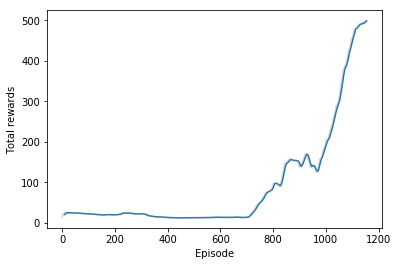

In [18]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

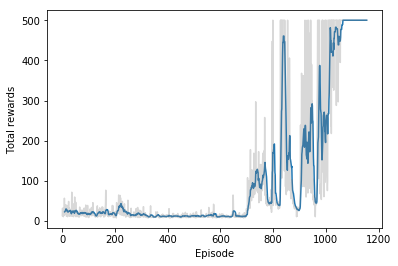

In [19]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

In [ ]:
eps, arr = np.array(gloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')`

In [ ]:
eps, arr = np.array(dloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [20]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(10):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: 500.0
total_reward: 500.0
total_reward: 468.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
